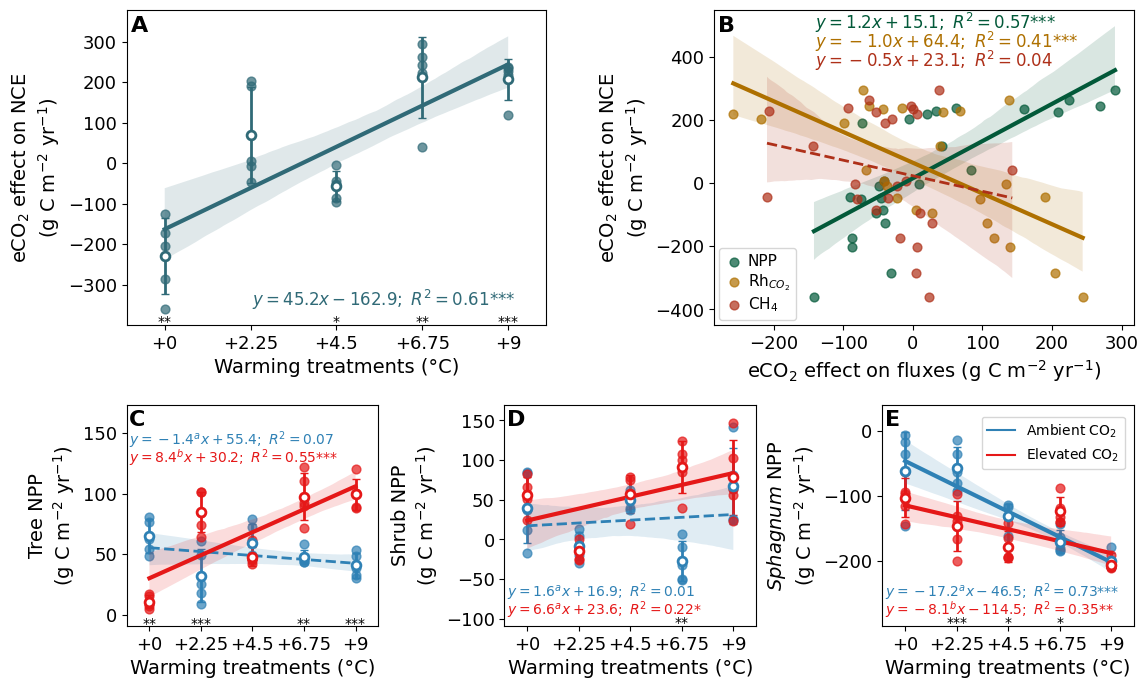

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy.stats import linregress, ttest_1samp, ttest_rel
import statsmodels.formula.api as smf

# ============================================================
# 0) CONFIG (edit here)
# ============================================================
CFG = {
    # ---------- files ----------
    "files": {
        "pft_file": "1_data_minus_2013.xlsx",
    },
    "analysis": {
        "year_min": 2017,
    },

    # ---------- layout ----------
    "fig": {"figsize": (13, 8)},
    "layout": {
        "outer_rows": 2,
        "outer_cols": 1,
        "outer_height_ratios": [1, 0.7],
        "outer_hspace": 0.30,
        "top": {"rows": 1, "cols": 2, "wspace": 0.40},
        "bottom": {"rows": 1, "cols": 3, "wspace": 0.50},
    },

    # ---------- warming axis ----------
    "warming": {
        "levels": [0, 2.25, 4.5, 6.75, 9],
        "labels": ["+0", "+2.25", "+4.5", "+6.75", "+9"],
        "xlim": (-1, 10),
        "xlabel": "Warming treatments (°C)",
    },

    # ---------- style ----------
    "style": {
        "tick_labelsize": 13,
        "panel_labelsize": 16,
        "panel_label_weight": "bold",
        "reg_lw_sig": 3,
        "reg_lw_nsig": 2,
        "scatter_s": 40,
        "scatter_alpha": 0.7,
        "err_capsize": 3,
        "err_lw": 2,
    },

    # ---------- colors ----------
    "colors": {
        "nce": "#306A77",
        "aco2": "#2F81B5",
        "eco2": "#E51818",
        "flux": {
            "gpp": "#214EA7",
            "ra":  "#F38B2F",
            "npp": "#025939",
            "rh":  "#AE7000",
            "ch4": "#AE3019",
        },
    },

    # ---------- labels ----------
    "labels": {
        "flux": {"gpp": "GPP", "npp": "NPP", "ra": "Ra", "rh": "Rh$_{CO_2}$", "ch4": "CH$_4$"},
        "y_nce": r"eCO$_2$ effect on NCE" + "\n" + r"(g C m$^{-2}$ yr$^{-1}$)",
        "x_flux": r"eCO$_2$ effect on fluxes (g C m$^{-2}$ yr$^{-1}$)",
        "y_tree": r"Tree NPP" + "\n" + r"(g C m$^{-2}$ yr$^{-1}$)",
        "y_shrub": r"Shrub NPP" + "\n" + r"(g C m$^{-2}$ yr$^{-1}$)",
        "y_sphag": r"$\it{Sphagnum}$ NPP" + "\n" + r"(g C m$^{-2}$ yr$^{-1}$)",
    },

    # ---------- limits ----------
    "limits": {
        "A_ylim": (-399, 379),
        "B_ylim": (-449, 549),
        "pft_ylims": {
            "npp_Tree": (-9, 173),
            "npp_Shrub": (-109, 169),
            "npp_Sphagnum": (-299, 39),
        },
        "pft_star_y": {"npp_Tree": -7, "npp_Shrub": -105, "npp_Sphagnum": -295},
        "A_star_y": -392,
    },

    # ---------- text positions ----------
    "text_pos": {
        "A_stats": (0.30, 0.06),
        "B_stats": [(0.24, 0.94), (0.24, 0.88), (0.24, 0.82)],  # NPP, Rh, CH4
        "pft_stats_y": {"npp_Tree": 0.82, "npp_Shrub": 0.13, "npp_Sphagnum": 0.13},
    },

    "panel_labels": ["A", "B", "C", "D", "E"],
}

# ============================================================
# 1) Small utilities
# ============================================================
def format_sig(p: float) -> str:
    if p < 0.001:
        return "***"
    if p < 0.01:
        return "**"
    if p < 0.05:
        return "*"
    return ""

def eq_text(slope, intercept, r2, p, superscript=None) -> str:
    sign = "-" if intercept < 0 else "+"
    sup = f"^{superscript}" if superscript else ""
    return f"$y = {slope:.1f}{sup}x {sign} {abs(intercept):.1f};\\ R^2={r2:.2f}$" + format_sig(p)

def dropna_xy(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    m = np.isfinite(x) & np.isfinite(y)
    return x[m], y[m]

def regression_plot(ax, x, y, color, label=None, scatter=True):
    """Scatter + regression line; returns (slope, intercept, r2, p)."""
    x, y = dropna_xy(x, y)
    if len(x) < 2:
        return np.nan, np.nan, np.nan, np.nan

    slope, intercept, r, p, _ = linregress(x, y)
    ls = "-" if p < 0.05 else "--"
    lw = CFG["style"]["reg_lw_sig"] if p < 0.05 else CFG["style"]["reg_lw_nsig"]

    sns.regplot(
        x=x, y=y, ax=ax, color=color, label=label,
        line_kws={"lw": lw, "linestyle": ls},
        scatter_kws=({"s": CFG["style"]["scatter_s"], "alpha": CFG["style"]["scatter_alpha"], "color": color}
                     if scatter else {"s": 0, "alpha": 0})
    )
    return slope, intercept, r * r, p

def plot_mean_std(ax, df, xcol, ycol, color, x_offset=0.0):
    """Mean ± std for each warming level."""
    g = df.groupby(xcol)[ycol].agg(["mean", "std"]).reset_index()
    ax.errorbar(
        g[xcol] + x_offset, g["mean"], yerr=g["std"],
        fmt="none", color=color,
        capsize=CFG["style"]["err_capsize"],
        linewidth=CFG["style"]["err_lw"],
        zorder=1
    )
    ax.scatter(
        g[xcol] + x_offset, g["mean"],
        s=CFG["style"]["scatter_s"],
        facecolor="white", edgecolor=color, linewidth=2, zorder=3
    )
    return g

def stars_vs_zero(ax, df, xcol, ycol, y_star, color="k", x_offset=0.0):
    """One-sample test vs 0 at each warming level."""
    for xval in CFG["warming"]["levels"]:
        vals = df.loc[df[xcol] == xval, ycol].values
        vals = vals[np.isfinite(vals)]
        if len(vals) < 2:
            continue
        _, p = ttest_1samp(vals, 0)
        s = format_sig(p)
        if s:
            ax.text(xval + x_offset, y_star, s, ha="center", va="center", color=color)

def stars_paired(ax, df, xcol, ycol, group_col, g1, g2, y_star, color="k"):
    """Paired test between two groups (co2=0 vs 500) at each warming."""
    for xval in CFG["warming"]["levels"]:
        v1 = df.loc[(df[xcol] == xval) & (df[group_col] == g1), ycol].values
        v2 = df.loc[(df[xcol] == xval) & (df[group_col] == g2), ycol].values
        v1 = v1[np.isfinite(v1)]
        v2 = v2[np.isfinite(v2)]
        if len(v1) < 2 or len(v2) < 2 or len(v1) != len(v2):
            continue
        _, p = ttest_rel(v1, v2)
        s = format_sig(p)
        if s:
            ax.text(xval, y_star, s, ha="center", va="center", color=color)

def slope_diff_ab(x1, y1, x2, y2):
    """
    Test slope difference via interaction: y ~ x + group + x:group
    Return ('a','b') if slopes differ (p<0.05), else ('a','a').
    """
    x1, y1 = dropna_xy(x1, y1)
    x2, y2 = dropna_xy(x2, y2)
    if len(x1) < 2 or len(x2) < 2:
        return ("a", "a")

    df = pd.DataFrame({
        "x": np.concatenate([x1, x2]),
        "y": np.concatenate([y1, y2]),
        "group": pd.Categorical(["aCO2"] * len(x1) + ["eCO2"] * len(x2))
    })
    m = smf.ols("y ~ x + group + x:C(group)", data=df).fit()

    # interaction term pvalue = slope difference
    p_int = None
    for term, pv in m.pvalues.items():
        if term.startswith("x:C(group)"):
            p_int = pv
            break

    if p_int is not None and p_int < 0.05:
        return ("a", "b")
    return ("a", "a")

def format_warming_axis(ax):
    ax.set_xlim(*CFG["warming"]["xlim"])
    ax.set_xticks(CFG["warming"]["levels"])
    ax.set_xticklabels(CFG["warming"]["labels"])
    ax.set_xlabel(CFG["warming"]["xlabel"], fontsize=14)

def add_panel_label(ax, label):
    ax.text(
        0.01, 0.98, label,
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=CFG["style"]["panel_labelsize"],
        fontweight=CFG["style"]["panel_label_weight"],
    )
    ax.tick_params(axis="x", labelsize=CFG["style"]["tick_labelsize"])
    ax.tick_params(axis="y", labelsize=CFG["style"]["tick_labelsize"])

# ============================================================
# 2) Data processing
# ============================================================
def read_pft_data(file_path, year_min):
    df = pd.read_excel(file_path)
    df = df[df["year"] >= year_min].copy()
    return df.reset_index(drop=True)

def calc_eco2_effect_from_pairs(df):
    """
    Compute eCO2 effect = (paired eCO2 plot) - (paired aCO2 plot) for each warming.
    Pairing order corresponds to warming levels: 0,2.25,4.5,6.75,9
    """
    vars_core = [
        "gpp_Tree", "gpp_Shrub", "gpp_Sphagnum",
        "ra_Tree",  "ra_Shrub",  "ra_Sphagnum",
        "npp_Tree", "npp_Shrub", "npp_Sphagnum",
        "rh", "ch4"
    ]
    warmings = CFG["warming"]["levels"]
    plot_pairs = [("P06", "P19"), ("P20", "P11"), ("P13", "P04"), ("P08", "P16"), ("P17", "P10")]

    df = df[["year", "plot", "warming", "co2"] + vars_core].copy()

    # derived variables
    df["nce"] = (
        (df["gpp_Tree"] + df["gpp_Shrub"] + df["gpp_Sphagnum"])
        - (df["ra_Tree"] + df["ra_Shrub"] + df["ra_Sphagnum"])
        - df["rh"] - df["ch4"]
    )
    df["npp"] = df["npp_Tree"] + df["npp_Shrub"] + df["npp_Sphagnum"]

    vars_all = vars_core + ["nce", "npp"]

    out = []
    for w, (p_a, p_e) in zip(warmings, plot_pairs):
        da = df[df["plot"] == p_a].copy()
        de = df[df["plot"] == p_e].copy()

        m = pd.merge(da, de, on="year", how="inner", suffixes=("_a", "_e"))
        tmp = pd.DataFrame({"year": m["year"], "warming": w})
        for v in vars_all:
            tmp[v] = m[f"{v}_e"] - m[f"{v}_a"]
        out.append(tmp)

    return pd.concat(out, ignore_index=True)

# ============================================================
# 3) Figure / axes
# ============================================================
def make_axes(fig):
    outer = GridSpec(
        CFG["layout"]["outer_rows"], CFG["layout"]["outer_cols"],
        height_ratios=CFG["layout"]["outer_height_ratios"],
        hspace=CFG["layout"]["outer_hspace"],
        figure=fig
    )
    gs_top = outer[0].subgridspec(
        CFG["layout"]["top"]["rows"], CFG["layout"]["top"]["cols"],
        wspace=CFG["layout"]["top"]["wspace"]
    )
    gs_bot = outer[1].subgridspec(
        CFG["layout"]["bottom"]["rows"], CFG["layout"]["bottom"]["cols"],
        wspace=CFG["layout"]["bottom"]["wspace"]
    )
    ax1 = fig.add_subplot(gs_top[0])
    ax2 = fig.add_subplot(gs_top[1])
    ax3 = fig.add_subplot(gs_bot[0])
    ax4 = fig.add_subplot(gs_bot[1])
    ax5 = fig.add_subplot(gs_bot[2])
    return ax1, ax2, ax3, ax4, ax5

# ============================================================
# 4) Panels
# ============================================================
def panel_A(ax, df_co2):
    color = CFG["colors"]["nce"]
    plot_mean_std(ax, df_co2, "warming", "nce", color)
    slope, intercept, r2, p = regression_plot(ax, df_co2["warming"], df_co2["nce"], color)

    stars_vs_zero(ax, df_co2, "warming", "nce", y_star=CFG["limits"]["A_star_y"])
    ax.text(*CFG["text_pos"]["A_stats"], eq_text(slope, intercept, r2, p),
            transform=ax.transAxes, color=color, fontsize=12)

    ax.set_ylim(*CFG["limits"]["A_ylim"])
    format_warming_axis(ax)
    ax.set_ylabel(CFG["labels"]["y_nce"], fontsize=14)

def panel_B(ax, df_co2):
    y = df_co2["nce"]

    show_vars = ["npp", "rh", "ch4"]  # editable
    stats_rows = []

    for v in show_vars:
        slope, intercept, r2, p = regression_plot(
            ax, df_co2[v], y, CFG["colors"]["flux"][v], label=CFG["labels"]["flux"][v]
        )
        stats_rows.append((v, slope, intercept, r2, p))

    ax.set_ylim(*CFG["limits"]["B_ylim"])
    ax.set_ylabel(CFG["labels"]["y_nce"], fontsize=14)
    ax.set_xlabel(CFG["labels"]["x_flux"], fontsize=14)

    # stats text
    for i, (v, slope, intercept, r2, p) in enumerate(stats_rows):
        x0, y0 = CFG["text_pos"]["B_stats"][i]
        ax.text(x0, y0, eq_text(slope, intercept, r2, p),
                transform=ax.transAxes, color=CFG["colors"]["flux"][v], fontsize=12)

    ax.legend(
        loc="lower left", ncol=1,
        labelspacing=0.2, columnspacing=0.7,
        handlelength=1.2, handletextpad=0.3,
        borderaxespad=0.3, fontsize=11
    )

def panel_PFT(ax, df_pft, var, ylabel, ylim, y_star):
    ax.set_ylim(*ylim)

    df_a = df_pft[df_pft["co2"] == 0].copy()
    df_e = df_pft[df_pft["co2"] == 500].copy()

    plot_mean_std(ax, df_a, "warming", var, CFG["colors"]["aco2"])
    plot_mean_std(ax, df_e, "warming", var, CFG["colors"]["eco2"])

    # a/b for slope difference
    ab = slope_diff_ab(df_a["warming"], df_a[var], df_e["warming"], df_e[var])

    # regression lines + equation text
    for i, (dd, col, sup) in enumerate([(df_a, CFG["colors"]["aco2"], ab[0]),
                                        (df_e, CFG["colors"]["eco2"], ab[1])]):
        slope, intercept, r2, p = regression_plot(ax, dd["warming"], dd[var], col)
        y_base = CFG["text_pos"]["pft_stats_y"][var]
        ax.text(0.01, y_base - 0.08 * i, eq_text(slope, intercept, r2, p, superscript=sup),
                transform=ax.transAxes, color=col, fontsize=10)

    # paired stars (aCO2 vs eCO2) at each warming
    stars_paired(ax, df_pft, "warming", var, "co2", 0, 500, y_star=y_star)

    format_warming_axis(ax)
    ax.set_ylabel(ylabel, fontsize=14)

# ============================================================
# 5) Main
# ============================================================
def main():
    fig = plt.figure(figsize=CFG["fig"]["figsize"])
    ax1, ax2, ax3, ax4, ax5 = make_axes(fig)

    # ----- read once
    df_pft = read_pft_data(CFG["files"]["pft_file"], CFG["analysis"]["year_min"])

    # ----- eCO2 effect (paired plots)
    df_co2 = calc_eco2_effect_from_pairs(df_pft)

    # ----- top row
    panel_A(ax1, df_co2)
    panel_B(ax2, df_co2)

    # ----- bottom row (PFT NPP)
    pft_panels = [
        ("npp_Tree", ax3, CFG["labels"]["y_tree"]),
        ("npp_Shrub", ax4, CFG["labels"]["y_shrub"]),
        ("npp_Sphagnum", ax5, CFG["labels"]["y_sphag"]),
    ]
    keep_cols = ["year", "plot", "warming", "co2"] + [v for v, _, _ in pft_panels]
    df_pft = df_pft[keep_cols].reset_index(drop=True)

    for var, ax, ylab in pft_panels:
        panel_PFT(
            ax=ax,
            df_pft=df_pft,
            var=var,
            ylabel=ylab,
            ylim=CFG["limits"]["pft_ylims"][var],
            y_star=CFG["limits"]["pft_star_y"][var],
        )

    # ----- CO2 legend on last axis
    handles = [
        plt.Line2D([], [], color=CFG["colors"]["aco2"], linestyle="-", label="Ambient CO$_2$"),
        plt.Line2D([], [], color=CFG["colors"]["eco2"], linestyle="-", label="Elevated CO$_2$"),
    ]
    ax5.legend(handles=handles, loc="upper right", bbox_to_anchor=(0.99, 0.98), fontsize=10)

    # ----- panel labels
    for ax, lab in zip([ax1, ax2, ax3, ax4, ax5], CFG["panel_labels"]):
        add_panel_label(ax, lab)

    plt.show()

if __name__ == "__main__":
    main()